In [6]:
# ! pip install nltk
# ! pip install torchtext
# ! pip install pytorch-nlp
# ! pip install transformers

     |████████████████████████████████| 7.0 MB 10.5 MB/s eta 0:00:01
     |████████████▌                   | 315.1 MB 119.4 MB/s eta 0:00:05

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |█████████████████████████▍      | 638.7 MB 118.8 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 804.1 MB 9.2 kB/s s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1


## Lab 2: Neural Machine Translation

In [1]:
import random
import imp
import math

import torch
from transformers import AutoModel

from preprocess import process_dataset, process_dataset_bert
import train
from score import show_results

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import os
path_to_data = 'data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [140]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


Length distribution in Train data


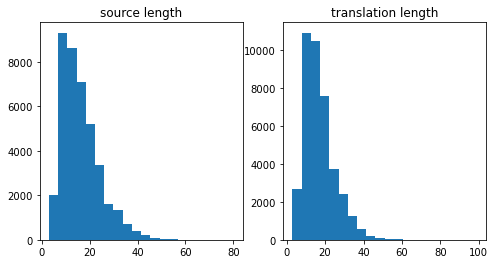

In [12]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


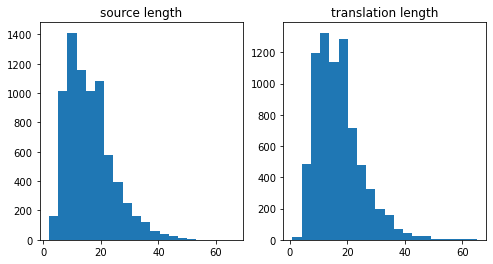

In [13]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [7]:
from models import baseline, GRU, GRU_attention, LSTM_attention, transformer, LSTM_BERT

### Baseline model (w/ higher number of epochs)

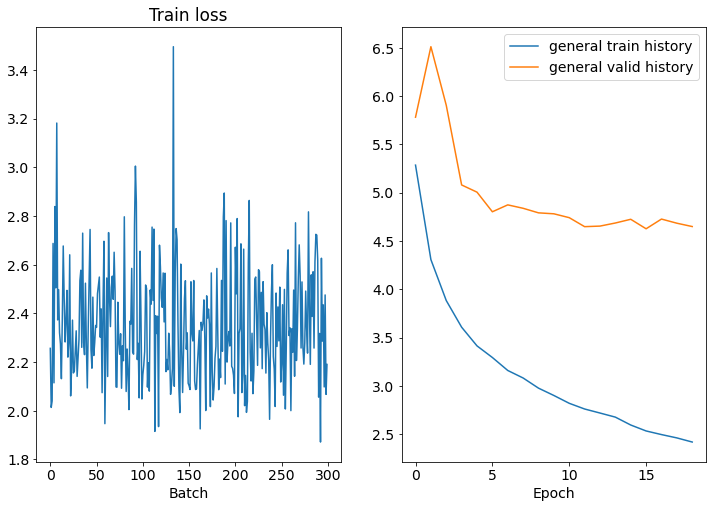

313it [01:45,  2.98it/s]


Epoch: 20 | Time: 1m 46s
	Train Loss: 2.348 | Train PPL:  10.467
	 Val. Loss: 4.674 |  Val. PPL: 107.085


In [142]:
base_model, test_iterator =  train.train_model(train_data, valid_data, test_data, SRC, TRG,
                                           baseline, 'baseline_20_epoch', batch_size=128, n_epochs=20)

In [150]:
show_results(base_model, test_iterator, TRG)

2it [00:00, 17.10it/s]

The model has 14,881,839 trainable parameters


59it [00:04, 12.14it/s]


BLEU: 17.23117099406496

original: this hotel in , madeira is located along the peaceful nova trail .
translated: this hotel is located on the edge of the national park .

original: the museum of ancient glass is 1 . 9 km from apartment , while palace of the general is 1 . 9 km away .
translated: is 1 . 8 km from , .

original: a hairdryer and free toiletries are included .
translated: slippers and a toiletries .

original: a traditional english afternoon tea and light snacks are served in the garden room .
translated: the english and are served in the and and a and a .

original: state university is 3 miles from the hotel .
translated: convention center is 2 . 8 km from the property .



In [190]:
train.load_best_model('baseline_20_epoch', baseline, SRC, TRG, test_iterator)

| Test Loss: 4.677 | Test PPL: 107.397 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6703, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6703, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

С увеличенным кол-вом эпох качество немного повысилось (относительно базового 13 BLEU), но перевод оставляет желать лучшего

### GRU with reversed TRG

В этом эксперименте попробуем заменить LSTM на GRU и отзеркалить target-последовательность

In [151]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data, reverse_trg=True)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6702


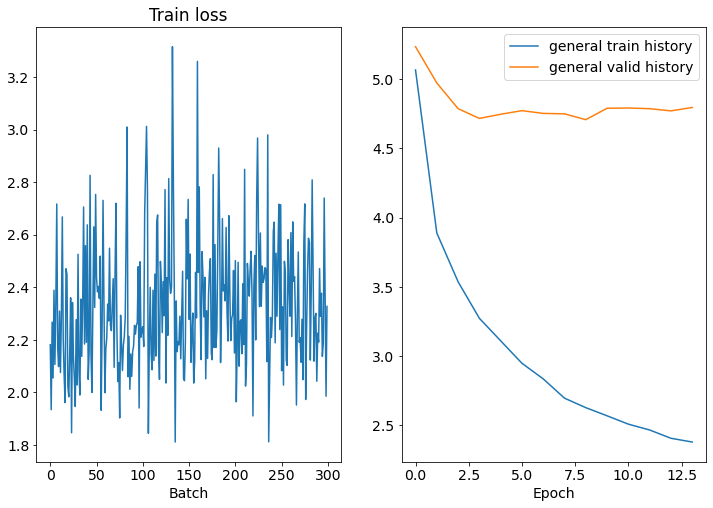

313it [01:37,  3.21it/s]


Epoch    15: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 15 | Time: 1m 38s
	Train Loss: 2.329 | Train PPL:  10.271
	 Val. Loss: 4.868 |  Val. PPL: 130.102


In [152]:
gru_rev_model, test_iterator =  train.train_model(train_data, valid_data, test_data, SRC, TRG,
                                           GRU, 'GRU_15_epoch_reversed', batch_size=128, n_epochs=15)

In [153]:
show_results(gru_rev_model, test_iterator, TRG)

3it [00:00, 22.23it/s]

The model has 13,041,966 trainable parameters


59it [00:04, 12.69it/s]


BLEU: 17.945913663464445

original: the rosa is 30 km from
translated: is 30 km from

original: there are 2 golf courses within a 5 - minute walk of the property
translated: golf course is a 5 - minute walk away

original: a sweet buffet breakfast is included
translated: breakfast is served daily

original: it also features a communal terrace with views over the gardens
translated: guests can enjoy a garden view from the garden

original: private bathrooms also come with a shower
translated: private bathroom comes with a shower



In [188]:
train.load_best_model('GRU_15_epoch_reversed', GRU, SRC, TRG, test_iterator)

| Test Loss: 4.741 | Test PPL: 114.495 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6702, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6702, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Качество подросло совсем незаметно. Переобучение происходит уже после 8 эпохи 

### GRU with Attention

Теперь попробуем добавить attention-блок (и зеркалить таргет уже не нужно)

In [154]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


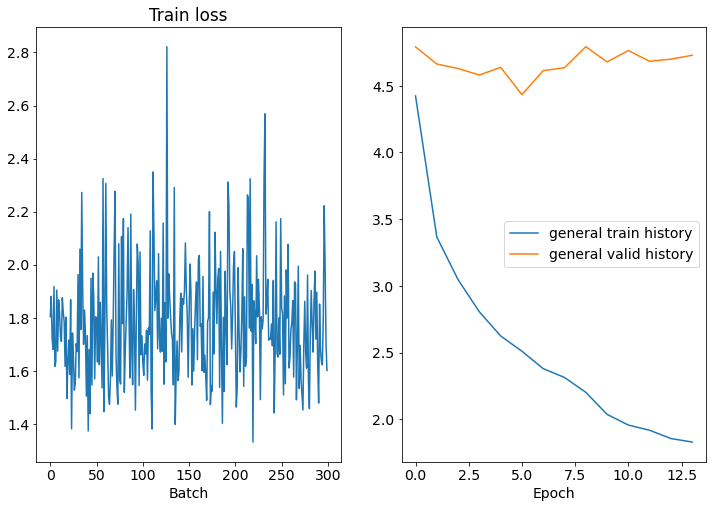

313it [02:05,  2.49it/s]


Epoch    15: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 15 | Time: 2m 7s
	Train Loss: 1.779 | Train PPL:   5.925
	 Val. Loss: 4.795 |  Val. PPL: 120.889


In [155]:
gru_attention_model, test_iterator = train_model(train_data, valid_data, test_data, SRC, TRG,
                                           GRU_attention, 'GRU_attention_15_epoch', batch_size=128, n_epochs=15)

In [156]:
show_results(gru_attention_model, test_iterator, TRG)

3it [00:00, 19.95it/s]

The model has 16,474,671 trainable parameters


59it [00:05, 11.50it/s]


BLEU: 27.994753919074412

original: it houses a restaurant and bar and offers free wi - fi access in its public areas .
translated: free wifi is available in the public areas and free wi - fi is available in public areas .

original: there is also an irish pub in the hostel .
translated: there is a full kitchen with an irish pub .

original: set in braşov , this apartment features a balcony with mountains views .
translated: set in , this apartment features a balcony with mountain views .

original: a grocery shop is 50 metres from studio rooms , while the nearest green market is 500 metres away .
translated: the grocery store is 50 metres away , while the nearest grocery market is 500 metres away the nearest nearest market is 500 metres away .

original: the suite features a view of the garden , a wardrobe , a seating area and tea and coffee making facilities .
translated: tea and tea and coffee making facilities are a seating area , a wardrobe and tea / coffee making facilities and a

In [186]:
train.load_best_model('GRU_attention_15_epoch', GRU_attention, SRC, TRG, test_iterator)

| Test Loss: 4.411 | Test PPL:  82.325 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6703, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention()
    (out): Linear(in_features=1024, out_features=6703, bias=True)
  )
)

Получили довольно ощутимый прирост качества, при этом наименьший лосс - на 5 эпохе 

### LSTM with attention from torchnlp

В этом эксперименте заменим наш DIY attention-блок на готовую реализацию из PyTorch-NLP

In [198]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


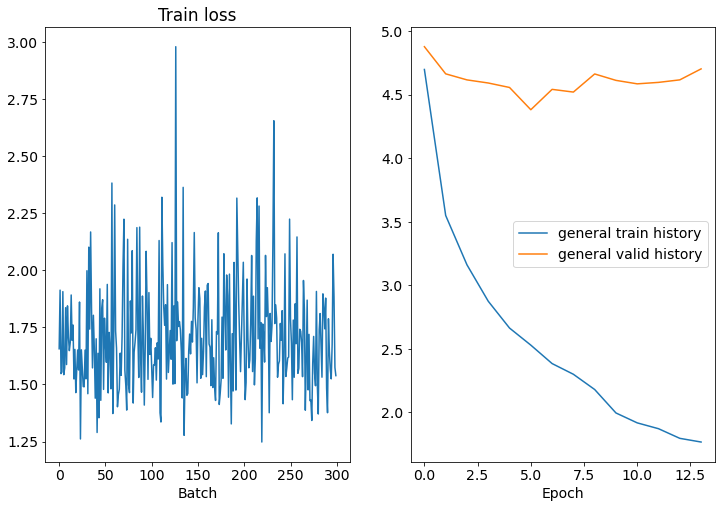

313it [02:17,  2.28it/s]


Epoch    15: reducing learning rate of group 0 to 1.2500e-04.
Epoch: 15 | Time: 2m 18s
	Train Loss: 1.709 | Train PPL:   5.525
	 Val. Loss: 4.713 |  Val. PPL: 111.354


In [199]:
lstm_attention_model, test_iterator = train_model(train_data, valid_data, test_data, SRC, TRG,
                                           LSTM_attention, 'LSTM_attention_15_epoch', batch_size=128, n_epochs=15)

In [200]:
show_results(lstm_attention_model, test_iterator, TRG)

2it [00:00, 18.79it/s]

The model has 19,100,207 trainable parameters


59it [00:05, 10.54it/s]


BLEU: 30.67971189270188

original: it houses a restaurant and bar and offers free wi - fi access in its public areas .
translated: a restaurant and a restaurant , and free wifi in public areas areas . free wifi is available in public areas .

original: there is also an irish pub in the hostel .
translated: guests can also find a designated on site .

original: set in braşov , this apartment features a balcony with mountains views .
translated: set in , this apartment features a balcony with mountain views .

original: a grocery shop is 50 metres from studio rooms , while the nearest green market is 500 metres away .
translated: a grocery store is 50 metres away and the nearest market is 500 metres away .

original: the suite features a view of the garden , a wardrobe , a seating area and tea and coffee making facilities .
translated: the air - conditioned suite features a seating area , a wardrobe and tea / coffee making facilities .



In [201]:
train.load_best_model('LSTM_attention_15_epoch', LSTM_attention, SRC, TRG, test_iterator)

| Test Loss: 4.389 | Test PPL:  80.561 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6703, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=1024, out_features=6703, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Похоже, что LSTM дружит с аттеншеном чуть лучше, чем GRU :) Либо библиотечная версия аттеншена оказалась оптимальней, чем реализованная вручную 

### Transformer

И, наконец, попробуем архитектуру из знаменитой статьи Attention Is All You Need

In [3]:
train_data, valid_data, test_data, SRC, TRG = process_dataset(path_to_data, bf=True)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9261
Unique tokens in target (en) vocabulary: 6703


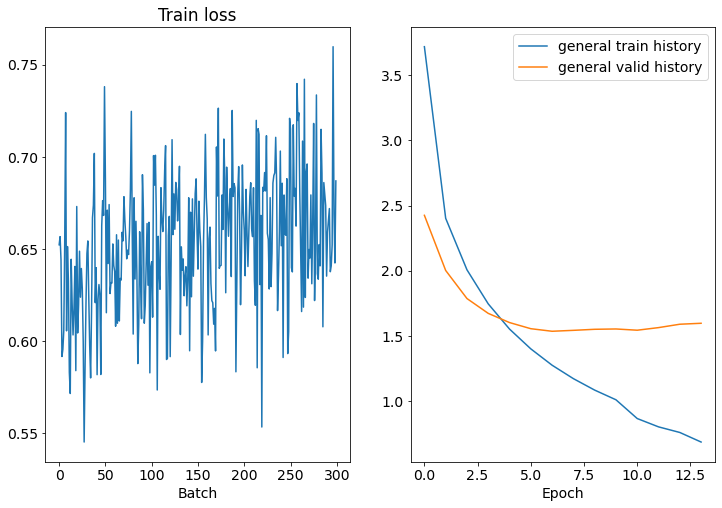

313it [00:40,  7.75it/s]


Epoch: 15 | Time: 0m 40s
	Train Loss: 0.654 | Train PPL:   1.923
	 Val. Loss: 1.618 |  Val. PPL:   5.043


In [192]:
transformer_model, test_iterator = train.train_transformer(train_data, valid_data, test_data, SRC, TRG,
                                           transformer, 'transformer_15_epoch_4heads', batch_size=128, n_epochs=15)

In [193]:
show_results(transformer_model, test_iterator, TRG, tr_flag=True)

0it [00:00, ?it/s]

The model has 9,814,319 trainable parameters


59it [00:55,  1.06it/s]


BLEU: 32.97207129799206

original: towels and bed linen are offered .
translated: towels and bed linen are available in this self - catering accommodation .

original: hotel grande operates a 24 - hour front desk to assist guests at all hours . it features 2 dining options and a free wifi connected business centre .
translated: hotel grande grande grande grande offers a 24 - hour front desk , 2 restaurants and a business centre with free wi - fi access .

original: offering panoramic views of the amalfi coast , le provides self - catering apartments with a sea - view balcony .
translated: le on the amalfi coast offers self - catered accommodation with panoramic sea views from their own balcony .

original: there is also a fully equipped kitchen with a stovetop , a refrigerator and a dining table .
translated: there is a full kitchen with a stove , fridge and dining table .

original: the bandaranaike international airport is located 73 km away .
translated: the nearest airport is banda

In [197]:
train.load_best_model('transformer_15_epoch_4heads', transformer, SRC, TRG, test_iterator, transformer=True)

| Test Loss: 1.510 | Test PPL:   4.527 |


Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9261, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

Ожидаемо, даже базовая реализация трансформера побила все предыдущие модели. Видимо, не зря на нем основаны многие SOTA-модели 

Перевод тоже получился довольно осмысленным, хоть и не без огрехов (к примеру, частые повторения слов никуда не делись). Одним словом, еще есть куда расти :)

### BERT pre-trained embeddings

возьмем архитектуру LSTM+torchnlp attention, но на вход энкодера будем подавать предобученные эмбеддинги RuBERT

In [70]:
train_data, valid_data, test_data, SRC, TRG = process_dataset_bert(path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 10771
Unique tokens in target (en) vocabulary: 6703


In [89]:
# rubert = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased")
rubert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

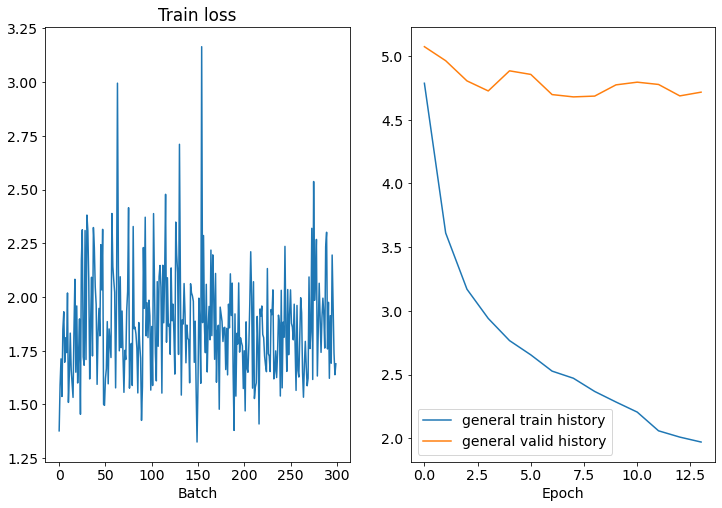

313it [02:52,  1.82it/s]


Epoch: 15 | Time: 2m 54s
	Train Loss: 1.869 | Train PPL:   6.479
	 Val. Loss: 4.823 |  Val. PPL: 124.322


In [93]:
bert_model, test_iterator = train.train_model(train_data, valid_data, test_data, SRC, TRG,
                                              LSTM_BERT, 'bert_15_epoch', batch_size=128, n_epochs=15,
                                              bert=True, bert_model=rubert)

In [ ]:
show_results(bert_model, test_iterator, TRG)

3it [00:00, 19.56it/s]

The model has 131,840,559 trainable parameters


59it [00:06,  8.69it/s]


BLEU: 26.1654786928771

original: it offers 2 outdoor swimming pools with views of the sea .
translated: the 2 - star hotel offers a outdoor swimming pool .

original: apartments is situated 38 km from pula airport .
translated: pula airport is 32 km from the .

original: the apartments offer air conditioning , satellite tv and seating area .
translated: air conditioning , satellite tv and a seating area are provided .

original: various services are offered by the property , such as an airport shuttle , luggage storage and laundry .
translated: other services offered at the property include an airport shuttle , luggage storage and laundry laundry .

original: a delivery service for fresh bread rolls is available on request for a surcharge .
translated: on request , and a surcharge , and a surcharge .



In [98]:
import train
imp.reload(train)

<module 'train' from '/home/ubuntu/nlp_lab2/train.py'>

In [100]:
train.load_best_model('bert_15_epoch', LSTM_BERT, SRC, TRG, test_iterator,
                      transformer=False, bert=True, bert_model=rubert)

| Test Loss: 4.669 | Test PPL: 106.634 |


Seq2Seq(
  (encoder): Encoder(
    (embedding): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (

Почему-то предобученные эмбеддинги не помогли достичь лучших результатов, даже по сравнению с самой простой реализацией attention'а

### Summary

| Model | Complexity (# of params) | Train time (1 epoch) | Inference time (1 batch) | BLEU score | Loss | Perplexity |
|------|------|------|------|------|------|------|
|  Baseline (LSTM, 20 epochs)  | 14.8M | 1m 47s | 0.07s | 17.2 | 4.67 | 107.4 |
|  GRU, reversed target  | 13M | 1m 38s | **0.07s** | 17.9 | 4.74 | 114.5 |
|  GRU with dot-product attention in Decoder | 16.5M | 2m 7s | 0.08s | 28 | 4.41 | 82.3 |
|  LSTM with torchnlp attention in Decoder  | 19.1M | 2m 18s | 0.08s | 30.7 | 4.39 | 80.5 |
|  **4-Headed Transformer**  | **9.8M** | **0m 40s** | 0.9s | **33** | **1.51** | **4.5** |
|  LSTM with torchnlp attention in Decoder and RuBERT pre-trained embeddings in Encoder | 131.8M | 2m 54s | 0.1s | 26.2 | 4.67 | 106.6 |



Можем сделать вывод, что эксперимент с трансформером показал наилучшие результаты по всем параметрам, кроме скорости инференса. Вероятно, это тоже можно оптимизировать, к сожалению не хватило времени на детальное исследование причины столь долгих расчетов.